# so this notebooks works at the moment for all tr plots, and maybe for the us plots, but not _licks. this is really because of an alignment issue with the names/output of the tuning_stability_values notebook. I'm pausing on this, and it says below where it stops working in comments

In [2]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)


Toggle code

In [3]:
# all modules necessary for this nb
import os
import sys
import pickle

import numpy as np
np.random.seed(0)
import pylab as pl
import scipy.stats as sstats

# setting parameters for default matplotlib plots
%matplotlib inline

In [4]:
pl.style.use('fabiostyle')
# needs to find the library of functions
sys.path.append('../../../code/')  # to be replaced!

import utils as ut
import plots as pt

In [5]:
NOTEBOOK_NAME = 'overlaps'

In [6]:
from pickleshare import PickleShareDB

autorestore_folder = os.path.join(os.getcwd(), 'autorestore', NOTEBOOK_NAME)
db = PickleShareDB(autorestore_folder)
import sys
from workspace import *
import IPython
ip = IPython.get_ipython()

# this will restore all the saved variables. ignore the errors listed.
# load_workspace(ip, db)

# use `save_worspace(db)` to save variables at the end

In [7]:
from itertools import product
def load_all_animals_vars(varname, animal_list, pilot_list=None, notebook='preprocessing'):
    all_of_them = {}
    for ani in animal_list:
        folder = '../%s/notebooks/autorestore/%s/' % (ani, notebook)
        all_of_them.update({ani: ut.load_variable(varname, folder)})
    return all_of_them

In [8]:
all_animals ='dhpcg1','dhpcg20','dhpc24'

print all_animals
animals = all_animals
prod = product(['3odor_pre', '3odor_post', '3odor_pre_rev', '3odor_post_rev',],
               ['rewardt', 'CSmt','sht'],
               ['_tr', '_us',],
               ['_up', '_dn'],
               )
for a, b, c, d in prod:
    values = []
    for ani in animals:
        try:
            values.append(ut.load_variable('cells_%s%s%s%s'%(a, b, c, d),
                                           '../%s/notebooks/autorestore/tuning_stability_values/'%ani))
        except IOError, e:
            print "No values for:", ani, a, b, c, d
            continue
    if len(values)>0:
        exec('cells_%s%s%s%s = np.concatenate(values)'%(a, b, c, d))

('dhpcg1', 'dhpcg20', 'dhpc24')


In [9]:
N = len(cells_3odor_postCSmt_tr_dn)
n_loops = 50000

def calc_shuffle_overlap(pop1, pop2, n_loops=500):
     return [(np.random.choice([0, 1], size=N, p=(1-pop1.mean(), pop1.mean()))*
                  np.random.choice([0, 1], size=N, p=(1-pop2.mean(), pop2.mean()))).mean() for r in range(n_loops)]

In [10]:
def sigtest(values, x):
    return [None, 1 - sstats.norm(np.mean(values), np.std(values)).cdf(x)]
def plot_hist(ax, vals, colors=['0.7', 'k'], bins=np.linspace(0, 0.05, 30), ids=[0, 1]):
    # ax.hist(vals2_all[0], bins=10, histtype='step', color='0.7')
    y, x = np.histogram(vals[ids[0]], bins=bins, normed=True)
    ax.step(x[:-1], y*np.diff(x)[0], color=colors[0], lw=1, where='post')
    ax.vlines(vals[ids[1]], 0, 0.4, color=colors[1], lw=1, zorder=19)
    y = np.diff(ax.axis()[-2:])*0.95 + ax.axis()[-2]
    pv = pt.add_significance(ax, vals[ids[0]], vals[ids[1]], vals[ids[1]], vals[ids[1]], y, sig_func=sigtest, ticksize=0)
    pt.nicer_plot(ax)
    return pv

In [11]:
def plot_it(pop1, pop2, untuned, est, labels=['Pre', 'Post', 'Pre+Post', 'Untuned'], title="Sucrose", percent=True,
            colors=[(1, 0., 0.2), (1, 0.5, 0.2), (1, 0.8, 0.2), (0.8, 0.8, 
                                                                 0.8)],
            hist_colors=[(1, 0.7, 0.7), 'r'], bins=np.linspace(0, 0.2, 30)):
    fig, axs = pl.subplots(1, 2, figsize=(3, 1))

    ax = axs[0]
    pv = plot_hist(ax, [est, (pop1*pop2).mean()], bins=bins,
            colors=hist_colors)

    ax.set_xlabel('Co-tuned Cells Ratio')
    ax.set_ylabel('PDF')

    ax.set_xlim(0, 0.2)
    ax.set_ylim(0, 0.5)

    ax = axs[1]
    
    t = map(sum, [pop1*~pop2, pop2*~pop1, pop1*pop2, untuned])
    total = np.sum(t)
    _, txts, _ = ax.pie(t, colors=colors, explode=[0.05]*len(t),
                        autopct=(lambda x: "%.1f%%"%(x)) if percent else lambda x: "%.1f"%(x*total/100),
                        labels=labels,
                        textprops={'fontsize':3})
    for tt in txts:
        tt.set_fontsize(5)
    ax.text(1, -1.3, 'n = %d'%total, fontsize=3)

    ax.set_aspect('equal')
    fig.suptitle(title)
    
    return fig, axs, pv

In [12]:
pop1 = cells_3odor_prerewardt_tr_up + cells_3odor_prerewardt_tr_dn
pop2 = cells_3odor_preCSmt_tr_up + cells_3odor_preCSmt_tr_dn
unt = ~(pop1 + pop2)
est = calc_shuffle_overlap(pop1, pop2, n_loops=n_loops)

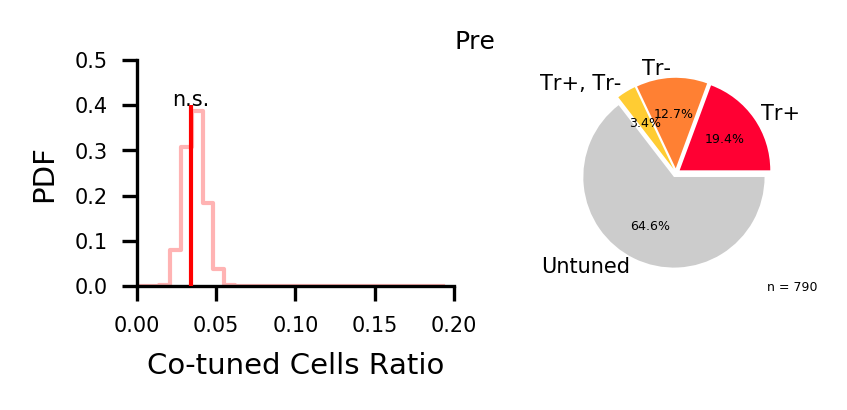

In [13]:
fig, axs, pv = plot_it(pop1, pop2, unt, est, labels=['Tr+', 'Tr-', 'Tr+, Tr-', 'Untuned'], title='Pre')
fig.savefig('../img/overlaps__CSp_CSm_pre.pdf')
np.savetxt('../img/overlaps__CSp_CSm_pre.pvs', [pv[-1]], header='One-sided t-test')

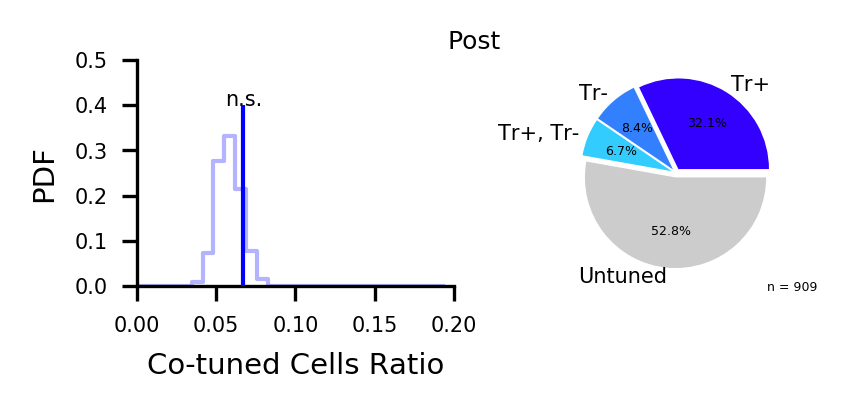

In [14]:
pop1 = cells_3odor_postrewardt_tr_up + cells_3odor_postrewardt_tr_dn
pop2 = cells_3odor_postCSmt_tr_up + cells_3odor_postCSmt_tr_dn
unt = ~(pop1 + pop2)
est = calc_shuffle_overlap(pop1, pop2, n_loops=n_loops)

fig, axs, pv = plot_it(pop1, pop2, unt, est, labels=['Tr+', 'Tr-', 'Tr+, Tr-', 'Untuned'], title='Post', 
                   colors=[(0.2, 0., 1), (0.2, 0.5, 1), (0.2, 0.8, 1), (0.8, 0.8, 0.8)],
                   hist_colors=[(0.7, 0.7, 1), 'b'])
fig.savefig('../img/overlaps__CSp_CSm_post.pdf')
np.savetxt('../img/overlaps__CSp_CSm_post.pvs', [pv[-1]], header='One-sided t-test')

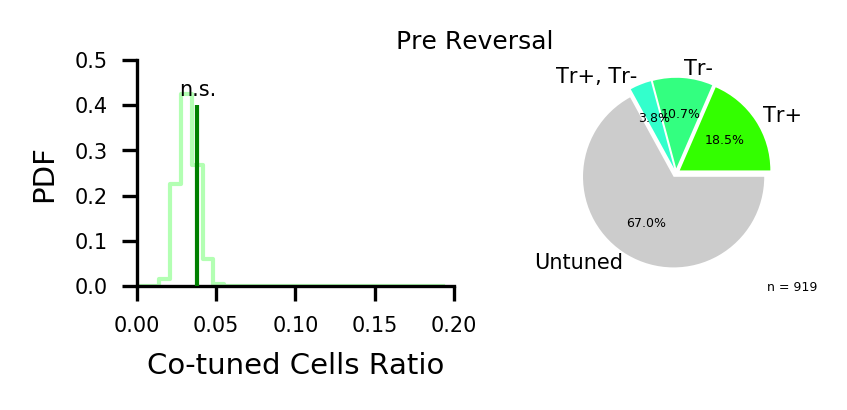

In [23]:
pop1 = cells_3odor_pre_revrewardt_tr_up + cells_3odor_pre_revrewardt_tr_dn
pop2 = cells_3odor_pre_revCSmt_tr_up + cells_3odor_pre_revCSmt_tr_dn
unt = ~(pop1 + pop2)
est = calc_shuffle_overlap(pop1, pop2, n_loops=n_loops)

fig, axs, pv = plot_it(pop1, pop2, unt, est, labels=['Tr+', 'Tr-', 'Tr+, Tr-', 'Untuned'], title='Pre Reversal', 
                   colors=[(0.2, 1, 0), (0.2, 1, .5), (0.2, 1, .8), (0.8, 0.8, 0.8)],
                   hist_colors=[(0.7, 1, 0.7), 'g'])
fig.savefig('../img/overlaps__CSp_CSm_ext1.pdf')
np.savetxt('../img/overlaps__CSp_CSm_ext1.pvs', [pv[-1]], header='One-sided t-test')

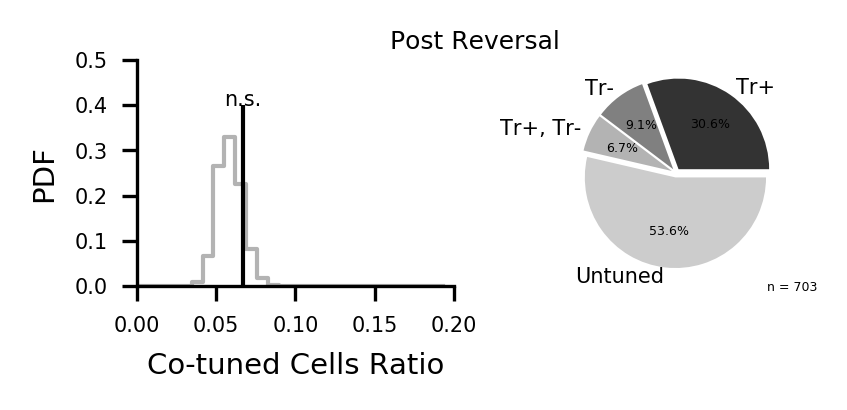

In [16]:
pop1 = cells_3odor_post_revrewardt_tr_up + cells_3odor_post_revrewardt_tr_dn
pop2 = cells_3odor_post_revCSmt_tr_up + cells_3odor_post_revCSmt_tr_dn
unt = ~(pop1 + pop2)
est = calc_shuffle_overlap(pop1, pop2, n_loops=n_loops)

fig, axs, pv = plot_it(pop1, pop2, unt, est, labels=['Tr+', 'Tr-', 'Tr+, Tr-', 'Untuned'], title='Post Reversal', 
                   colors=[(0.2, 0.2, 0.2), (0.5, 0.5, 0.5), (0.7, 0.7, 0.7), (0.8, 0.8, 0.8)],
                   hist_colors=[(0.7, 0.7, 0.7), 'k'])
fig.savefig('../img/overlaps__CSp_CSm_ext2.pdf')
np.savetxt('../img/overlaps__CSp_CSm_ext2.pvs', [pv[-1]], header='One-sided t-test')

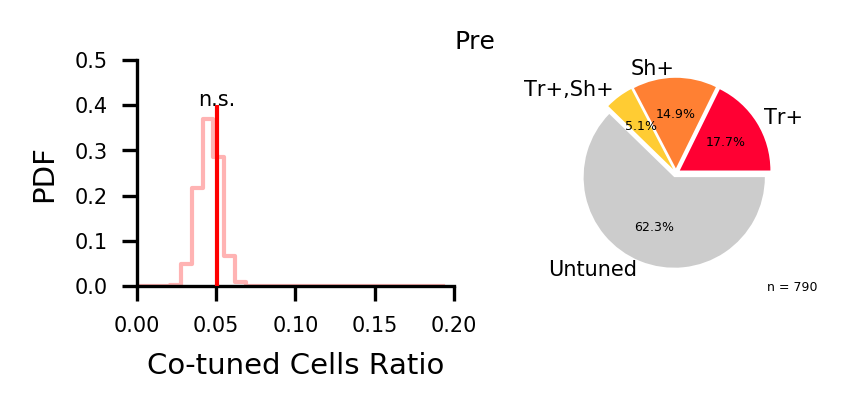

In [25]:
pop1 = cells_3odor_prerewardt_tr_up + cells_3odor_prerewardt_tr_dn
pop2 = cells_3odor_presht_tr_up + cells_3odor_presht_tr_dn
unt = ~(pop1 + pop2)
est = calc_shuffle_overlap(pop1, pop2, n_loops=n_loops)

fig, axs, pv = plot_it(pop1, pop2, unt, est, labels=['Tr+', 'Sh+', 'Tr+,Sh+', 'Untuned'], title='Pre', 
                   colors=[(1, 0., 0.2), (1, 0.5, 0.2), (1, 0.8, 0.2), (0.8, 0.8, 
                                                                 0.8)],
                   hist_colors=[(1, 0.7, .7), 'r'])
fig.savefig('../img/overlaps__CSp_sh_.pdf')
np.savetxt('../img/overlaps__CSp_sh_pre.pvs', [pv[-1]], header='One-sided t-test')

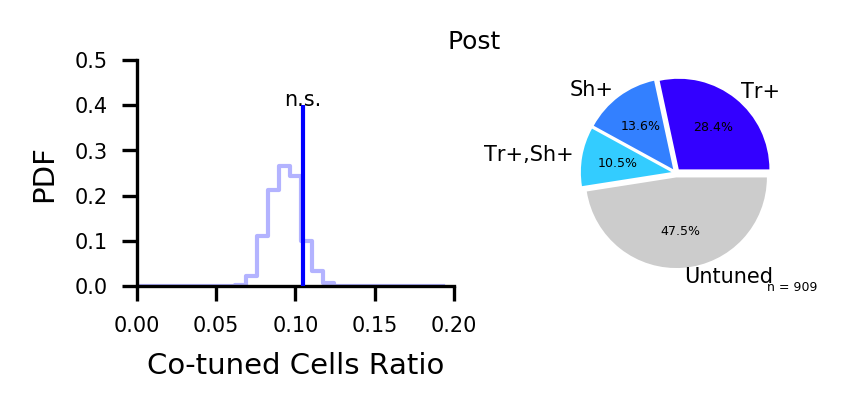

In [28]:
pop1 = cells_3odor_postrewardt_tr_up + cells_3odor_postrewardt_tr_dn
pop2 = cells_3odor_postsht_tr_up + cells_3odor_postsht_tr_dn
unt = ~(pop1 + pop2)
est = calc_shuffle_overlap(pop1, pop2, n_loops=n_loops)

fig, axs, pv = plot_it(pop1, pop2, unt, est, labels=['Tr+', 'Sh+', 'Tr+,Sh+', 'Untuned'], title='Post', 
                   colors=[(0.2, 0., 1), (0.2, 0.5, 1), (0.2, 0.8, 1), (0.8, 0.8, 0.8)],
                   hist_colors=[(0.7, 0.7, 1), 'b'])
fig.savefig('../img/overlaps__CSp_sh_.pdf')
np.savetxt('../img/overlaps__CSp_sh_pre.pvs', [pv[-1]], header='One-sided t-test')

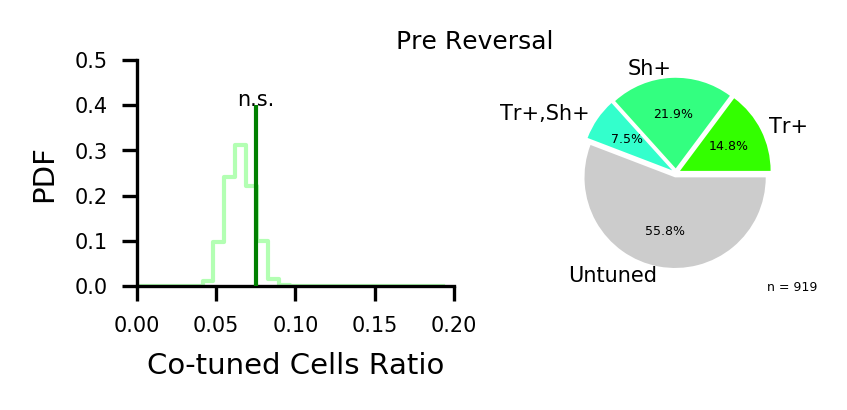

In [19]:
pop1 = cells_3odor_pre_revrewardt_tr_up + cells_3odor_pre_revrewardt_tr_dn
pop2 = cells_3odor_pre_revsht_tr_up + cells_3odor_pre_revsht_tr_dn
unt = ~(pop1 + pop2)
est = calc_shuffle_overlap(pop1, pop2, n_loops=n_loops)

fig, axs, pv = plot_it(pop1, pop2, unt, est, labels=['Tr+', 'Sh+', 'Tr+,Sh+', 'Untuned'], title='Pre Reversal', 
                   colors=[(0.2, 1, 0), (0.2, 1, .5), (0.2, 1, .8), (0.8, 0.8, 0.8)],
                   hist_colors=[(0.7, 1, .7), 'g'])
fig.savefig('../img/overlaps__CSp_sh_.pdf')
np.savetxt('../img/overlaps__CSp_sh_pre.pvs', [pv[-1]], header='One-sided t-test')

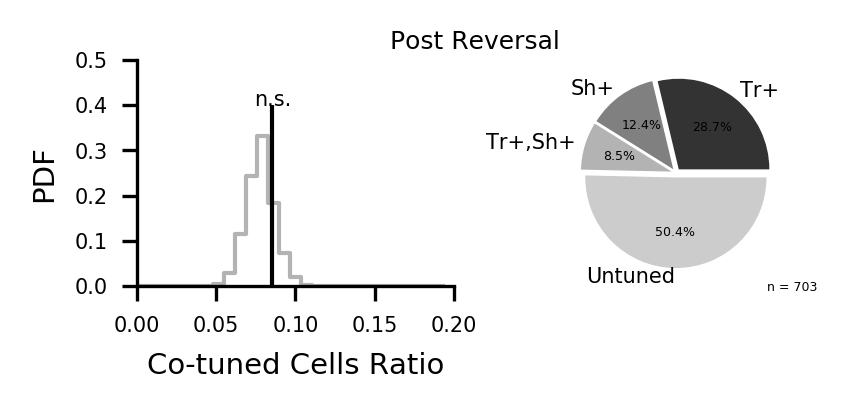

In [27]:
pop1 = cells_3odor_post_revrewardt_tr_up + cells_3odor_post_revrewardt_tr_dn
pop2 = cells_3odor_post_revsht_tr_up + cells_3odor_post_revsht_tr_dn
unt = ~(pop1 + pop2)
est = calc_shuffle_overlap(pop1, pop2, n_loops=n_loops)

fig, axs, pv = plot_it(pop1, pop2, unt, est, labels=['Tr+', 'Sh+', 'Tr+,Sh+', 'Untuned'], title='Post Reversal', 
                   colors=[(0.2, 0.2, 0.2), (0.5, 0.5, 0.5), (0.7, 0.7, 0.7), (0.8, 0.8, 0.8)],
                   hist_colors=[(0.7, 0.7, 0.7), 'k'])
fig.savefig('../img/overlaps__CSp_sh_.pdf')
np.savetxt('../img/overlaps__CSp_sh_pre.pvs', [pv[-1]], header='One-sided t-test')

In [21]:
pop1 = cells_prerewardt_tr_up + cells_prerewardt_tr_dn
pop2 = cells_prerewardt_us_up + cells_prerewardt_us_dn

unt = ~(pop1 + pop2)
est = calc_shuffle_overlap(pop1, pop2, n_loops=n_loops)

fig, axs, pv = plot_it(pop1, pop2, unt, est, labels=['Tr+', 'reward', 'Tr+,reward', 'Untuned'], title='Pre')
fig.savefig('../img/overlaps__CSp-us_CSp_pre.pdf')
np.savetxt('../img/overlaps__CSp-us_CSp_pre.pvs', [pv[-1]], header='One-sided t-test')

NameError: name 'cells_prerewardt_tr_up' is not defined

In [ ]:
pop1 = cells_postrewardt_tr_up + cells_postrewardt_tr_dn
pop2 = cells_postrewardt_us_up + cells_postrewardt_us_dn
unt = ~(pop1 + pop2)
est = calc_shuffle_overlap(pop1, pop2, n_loops=n_loops)

fig, axs, pv = plot_it(pop1, pop2, unt, est, labels=['CS+', 'reward', 'CS+,reward', 'Untuned'], title='Post', 
                   colors=[(0.2, 0., 1), (0.2, 0.5, 1), (0.2, 0.8, 1), (0.8, 0.8, 0.8)],
                   hist_colors=[(0.7, 0.7, 1), 'b'])
fig.savefig('../img/overlaps__CSp-us_CSp_post.pdf')
np.savetxt('../img/overlaps__CSp-us_CSp_post.pvs', [pv[-1]], header='One-sided t-test')

In [ ]:
pop1 = cells_renewrewardt_tr_up + cells_renewrewardt_tr_dn
pop2 = cells_renewrewardt_us_up + cells_renewrewardt_us_dn
unt = ~(pop1 + pop2)
est = calc_shuffle_overlap(pop1, pop2, n_loops=n_loops)

fig, axs, pv = plot_it(pop1, pop2, unt, est, labels=['CS+', 'reward', 'CS+,reward', 'Untuned'], title='Renew', 
                   colors=[(0.2, 1, 0), (0.2, 1, .5), (0.2, 1, .8), (0.8, 0.8, 0.8)],
                   hist_colors=[(0.7, 1, .7), 'g'])
fig.savefig('../img/overlaps__CSp-us_CSp_renew.pdf')
np.savetxt('../img/overlaps__CSp-us_CSp_renew.pvs', [pv[-1]], header='One-sided t-test')

The below won't run, licks is a think in the JSB tuning stability notebooks but not the non_JSB so that would have to be imported instead

In [ ]:
pop1 = cells_preCS_up_licks + cells_preCS_dn_licks
pop2 = cells_preCS_up + cells_preCS_dn
unt = ~(pop1 + pop2)
est = calc_shuffle_overlap(pop1, pop2, n_loops=n_loops)

fig, axs, pv = plot_it(pop1, pop2, unt, est, labels=['reward', 'CS+', 'CS+,reward', 'Untuned'], title='Pre')
fig.savefig('../img/overlaps__CSp-licks_CSp_pre.pdf')
np.savetxt('../img/overlaps__CSp-licks_CSp_pre.pvs', [pv[-1]], header='One-sided t-test')

In [ ]:
pop1 = cells_postCS_up_licks + cells_postCS_dn_licks
pop2 = cells_postCS_up + cells_postCS_dn
unt = ~(pop1 + pop2)
est = calc_shuffle_overlap(pop1, pop2, n_loops=n_loops)

fig, axs, pv = plot_it(pop1, pop2, unt, est, labels=['reward', 'CS+', 'CS+,reward', 'Untuned'], title='Post', 
                   colors=[(0.2, 0., 1), (0.2, 0.5, 1), (0.2, 0.8, 1), (0.8, 0.8, 0.8)],
                   hist_colors=[(0.7, 0.7, 1), 'b'])
fig.savefig('../img/overlaps__CSp-licks_CSp_post.pdf')
np.savetxt('../img/overlaps__CSp-licks_CSp_post.pvs', [pv[-1]], header='One-sided t-test')

In [ ]:
pop1 = cells_renewCS_up_licks + cells_renewCS_dn_licks
pop2 = cells_renewCS_up + cells_renewCS_dn
unt = ~(pop1 + pop2)
est = calc_shuffle_overlap(pop1, pop2, n_loops=n_loops)

fig, axs, pv = plot_it(pop1, pop2, unt, est, labels=['reward', 'CS+', 'CS+,reward', 'Untuned'], title='Renew', 
                   colors=[(0.2, 1, 0), (0.2, 1, .5), (0.2, 1, .8), (0.8, 0.8, 0.8)],
                   hist_colors=[(0.7, 1, .7), 'g'])
fig.savefig('../img/overlaps__CSp-licks_CSp_renew.pdf')
np.savetxt('../img/overlaps__CSp-licks_CSp_renew.pvs', [pv[-1]], header='One-sided t-test')

In [ ]:
save_workspace(db)